In [1]:
%reset

In [25]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn

In [26]:
directory = '../data/'
folder = "double_well_20/"
dynamics = "double_well"

In [ ]:
directory = '../data/'
folder = "mass_spring_10/"
dynamics = "mass_spring"

In [2]:
directory = '../data/'
folder = "henon_heiles_5/"
dynamics = "henon_heiles"

In [4]:
directory = '../data/'
folder = "coupled_ho_10/"
dynamics = "coupled_ho"
alpha = 0.5

In [27]:
train_file_path = directory + folder + dynamics+"_train.pt"
val_file_path = directory + folder + dynamics+"_val.pt"
test_file_path = directory + folder + dynamics+"_test.pt"
noisy_train_file_path = directory + folder + "noisy_" + dynamics + "_train.pt"
noisy_val_file_path = directory + folder + "noisy_" + dynamics + "_val.pt"
noisy_test_file_path = directory + folder + "noisy_" + dynamics + "_test.pt"

In [28]:
train_noisy = torch.load(noisy_train_file_path)
val_noisy = torch.load(noisy_val_file_path)
test_noisy = torch.load(noisy_val_file_path)

train = torch.load(train_file_path)
val = torch.load(val_file_path)
test = torch.load(val_file_path)

/tmp/ipykernel_4928/2106741414.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_noisy = torch.load(noisy_train_file_path)
/tmp/ipykernel_4928/2106741414.py:2: Futur

In [ ]:
def mass_spring(y, args, kargs):
    q = y[:, 0]
    p = y[:, 1]
    dq_dt = p
    dp_dt = -q
    return torch.stack((dq_dt, dp_dt), dim=-1)

: 

In [29]:
# Dynamics for double well system
def double_well(y, args, kargs):
    q = y[:, 0]
    p = y[:, 1]
    dq_dt = p
    dp_dt = q - q**3
    return torch.stack((dq_dt, dp_dt), dim=-1)

In [ ]:
# Dynamics for the chaotic system (henon-heiles)
def henon_heiles(y, args, kargs):
    q1, q2, p1, p2 = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
    
    dq1 = p1
    dq2 = p2
    dp1 = -q1 - 2 * q1 * q2
    dp2 = -q2 - q1**2 + q2**2
    
    return torch.stack((dq1, dq2, dp1, dp2), dim=-1)

In [305]:
# Dynamics for the non-separable Hamiltonian system
def coupled_ho(y, args, kargs):
    #alpha = args
    #alpha = 0.5
    q, p = y[:, 0], y[:, 1]
    dqdt = p + alpha * q
    dpdt = -q - alpha * p
    return torch.stack((dqdt, dpdt), dim=-1)

In [30]:
# Computes the time derivative of the system state using Hamiltonian-based dynamics.
def forward_ode(y_tensor, args, kargs):

    model = args[0]
    i = kargs[0]
    br_i = y_tensor.shape[1]//2
        
    with torch.enable_grad():

        y = y_tensor.clone().detach().requires_grad_(True)

        h = model(y)

    
        grad_h = torch.autograd.grad(outputs=h.sum(), inputs=y, create_graph=True, retain_graph=True, allow_unused=True)[0]

        #print("grad h: ", grad_h)
        dq_dt = grad_h[:, br_i:2*br_i]
        dp_dt = -grad_h[:, 0:br_i]

    return torch.cat((dq_dt, dp_dt), dim=-1)

In [31]:
# The HNN model class (definition is needed as we save the entire model)
class HamiltonianNN(nn.Module):
    # For now the input data is passed as init parameters
    def __init__(self, model_specs):
        super(HamiltonianNN, self).__init__()

        # Create a list of linear layers based on layer_sizes
        layer_sizes = model_specs[0]
        self.layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        self.RANDOM_SEED = 0
        for i in range(len(layer_sizes) - 2):  # All layers except the last one
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1], bias=True))

            self.dropout_layers.append(nn.Dropout(p=0.2))
        
        # Last layer without bias
        self.layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1], bias=False))

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            x = torch.tanh(x)
            if i < len(self.dropout_layers):
                x = self.dropout_layers[i](x)
        x = self.layers[-1](x)
        return x

In [32]:
## Not necessary ##
def get_dynamics_plot(y, model, dynamics, args):
    
    pred_dyn = forward_ode(y, (model,), (0,))
    true_dyn = dynamics(y, args, None)
    return pred_dyn, true_dyn

In [33]:
############ If using the IM integrator ###############
############ Run this only ###############

def rk2_step(dyn, y, dt, dynamics, args, kargs):
    h = dt
    i = kargs[0]
    br_i = y.shape[1]//2
    q, p = y[:, 0:br_i], y[:, br_i:2*br_i]


    dy1 = dynamics(y, args, kargs)
    q1 = q + 0.5 * dy1[:, 0:br_i] * h
    p1 = p + 0.5 * dy1[:, br_i:2*br_i] * h

    y1 = torch.cat((q1, p1), dim=-1)
    dy2 = dynamics(y1, args, kargs)

    q_new = q + dy2[:, 0:br_i] * h
    p_new = p + dy2[:, br_i:2*br_i] * h
    return torch.cat((q_new, p_new), dim=-1)



def im_step(dyn, y, dt, dynamics, iterations, y_init, args, kargs):
    h = dt
    br_i = y.shape[1] // 2
    q, p = y[:, 0:br_i], y[:, br_i:2 * br_i]
    
    y_init_concat = torch.cat((y_init[:, 0:br_i], y_init[:, br_i:2*br_i]), dim=-1)  # Shape [batch, 2]
    f_init = dynamics(y_init_concat, args, kargs)  # Compute dynamics at initial point
    
    q_new = q + 0.5 * h * f_init[:, 0:br_i]  # Shape [batch, 1]
    p_new = p + 0.5 * h * f_init[:, br_i:2*br_i]  # Shape [batch, 1]

    for _ in range(iterations):
        mid_q = 0.5 * (q + q_new)  # Shape [batch, q_shape]
        mid_p = 0.5 * (p + p_new)  # Shape [batch, p_shape]
        
        mid_concat = torch.cat((mid_q, mid_p), dim=-1)  # Ensure [batch, 2*q_shape]
        f_mid = dynamics(mid_concat, args, kargs)  # Compute dynamics at midpoint
        
        q_new = q + h * f_mid[:, 0:br_i]  # Shape [batch, q_shape]
        p_new = p + h * f_mid[:, br_i:2*br_i]  # Shape [batch, p_shape]

    return torch.cat((q_new, p_new), dim=-1)  # Final shape [batch, 2*q_shape]


def solve_ivp_custom_ms_im(dynamics, dyn, pred, y_data, t_span, dt, shooting_segment_length, number_of_shooting_segments, args, iters):
    t0, t1 = t_span
    shooting_nodes = [y_data[:, i * shooting_segment_length, :] for i in range(number_of_shooting_segments + 1)]
    segments = []
    cont_errors = []
    
    for seg in range(number_of_shooting_segments):
        y_seg = shooting_nodes[seg]
        seg_states = [y_seg]
        
        for j in range(1, shooting_segment_length + 1):
            step_index = seg * shooting_segment_length + j
            if pred=="True":
                y_ = rk2_step(dyn, y_seg, dt, dynamics, args, kargs=(step_index,))
            else:
                y_ = y_data[:, step_index, :]
            y_next = im_step(dyn, y_seg, dt, dynamics, iters, y_, args, kargs=(step_index,))
            seg_states.append(y_next)
            y_seg = y_next
        
        seg_states = torch.stack(seg_states, dim=1)
        segments.append(seg_states)
        
        cont_error = y_seg - shooting_nodes[seg + 1]
        cont_errors.append(cont_error)
    
    full_traj = segments[0]
    for seg in segments[1:]:
        full_traj = torch.cat((full_traj, seg[:, 1:, :]), dim=1)
    
    return full_traj, cont_errors

In [ ]:
############ If using the SV integrator ###############
############ Not required here ###############

def rk2_step(dyn, y, dt, dynamics, args, kargs):
    h = dt
    i = kargs[0]
    q, p = y[:, 0], y[:, 1]

    #y = torch.stack((q, p), dim=-1)  # Shape: (batch_size, 2)

    #print(q.shape)

    dy1 = dynamics(y, args, kargs)
    q1 = q + 0.5 * dy1[:, 0] * h
    p1 = p + 0.5 * dy1[:, 1] * h

    y1 = torch.stack((q1, p1), dim=-1)  # Shape: (batch_size, 2)
    dy2 = dynamics(y1, args, kargs)

    q_new = q + dy2[:, 0] * h
    p_new = p + dy2[:, 1] * h
    return torch.stack((q_new, p_new), dim=-1)


def sv_step(dyn, y, dt, dynamics, iterations, y_init, args, kargs):
    h = dt
    q, p = y[:, 0], y[:, 1]
    i = kargs[0]

    p_half = p + 0.5 * h * dynamics(torch.stack((q, y_init[:, 1]), dim=-1), args, kargs)[:, 1]
    for _ in range(iterations):
        p_half = p + 0.5 * h * dynamics(torch.stack((q, p_half), dim=-1), args, kargs)[:, 1]

    q_half = q + 0.5 * h * dynamics(torch.stack((y_init[:, 0], p_half), dim=-1), args, kargs)[:, 0]
    for _ in range(iterations):
        q_half = q + 0.5 * h * dynamics(torch.stack((q_half, p), dim=-1), args, kargs)[:, 0]

    q_new = q + h * dynamics(torch.stack((q_half, p_half), dim=-1), args, kargs)[:, 0]
    p_new = p_half + 0.5 * h * dynamics(torch.stack((q_new, p_half), dim=-1), args, kargs)[:, 1]

    return torch.stack((q_new, p_new), dim=-1)


def solve_ivp_custom_ms_sv(dynamics, dyn, y_batch, t_span, dt, args, iters):
    #t = torch.arange(0, T, dt)
    batch_size = y_batch.shape[0]
    t0, t1 = t_span
    t = 0.1
    if t0 > t1:
        dt = -dt
    num_steps = int((t1 - t0) / t)
    ys_batch = []
    for i in range(0, num_steps):
        if i == 0:
            y = y_batch[:,0,:]
            ys_batch.append(y)
        else:
            y = y_batch[:,len(ys_batch)-1,:]
            ys_batch[-1] = y
        for j in range(1, int(t/dt)+1):
            y = ys_batch[-1]
            y_ = rk2_step(dyn, y, dt, dynamics, args, kargs=(j,))
            y_next = sv_step(dyn, y, dt, dynamics, iters, y_, args, kargs=(j,))
            ys_batch.append(y_next)
    ys_batch = torch.stack(ys_batch, dim=1)
    return ys_batch

: 

In [34]:
### No need to run unless you wanna generate some trajectories ###
def gen_trajs(noisy_val_trajs, model):
    #pq0_batch = true_val_trajectories[0:128, 0, :]
    dt_solve=0.01
    #T=20.0
    T=10.0
    pq0_batch = noisy_val_trajs[0:20, :, :]
    pred = "True"
    sim_len = 2
    sims = 500
    y_pred_batch, const_errors = solve_ivp_custom_ms_im(forward_ode, "forward", pred, pq0_batch, (0, T), dt_solve,
                sim_len, sims, args=(model,), iters=6)
    #y_pred_batch = solve_ivp_custom_ms_sv(forward_ode, "forward", pq0_batch, (0, T), dt_solve, args=(model,), iters=5)
    return y_pred_batch

In [35]:
# Load the model
########### Choose a saved model ###############

#model = torch.load('/home/harsh/HNN/models/model_0_coupled_ho_0.0_adjoint_True_7_im.pt')
model = torch.load('/home/harsh/HNN/models/model_0_double_well_0.0_adjoint_True_7_im.pt')
#model = torch.load('/home/harsh/HNN/models/model_0_henon_heiles_0.0_adjoint_True_7_im.pt')
model.eval()  # Set the model to evaluation mode


/tmp/ipykernel_4928/2609860485.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/home/harsh/HNN/models/model_0_double_well_0.0_adjoint_True_7_im.pt')


HamiltonianNN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=1, bias=False)
  )
  (dropout_layers): ModuleList(
    (0-2): 3 x Dropout(p=0.2, inplace=False)
  )
)

In [36]:
pred_trajs = gen_trajs(test, model)

In [37]:
# For 2D dynamics run this
h = torch.zeros((6, test.shape[1]))
p_0 = test[0:1000, 0, 1]
q_0 = test[0:1000, 0, 0]

In [338]:
# Just for the Henon Heiles dynamics as the phase space is 4D
h = torch.zeros((6, test.shape[1]))
p_0 = test[0:1000, 0, 2]
p_1 = test[0:1000, 0, 3]
q_0 = test[0:1000, 0, 0]
q_1 = test[0:1000, 0, 1]

In [ ]:
x = q_0.unsqueeze(dim=1)
x.shape

torch.Size([1000, 1])

: 

In [38]:

### Hamiltonian Spring Mass ###
#true_h_0 = (0.5*p_0**2) + (0.5*q_0**2)

### Hamiltonian Double Well ###
true_h_0 = (0.5*(p_0**2) + 0.25*(q_0**4) - 0.5*(q_0**2))

### Hamiltonian coupled oscillator ###
#alpha = 0.5
#true_h_0 = (0.5*p_0**2) + (0.5*q_0**2) + alpha*q_0*p_0

### Hamiltonian Henon Heiles ###
#true_h_0 = (0.5*(p_0**2 + p_1**2) + 0.5*(q_0**2 + q_1**2) + (q_0**2)*(q_1)  -((q_1**3)/3))

#Henon Heiles
#pred_h_0 = model(torch.stack((q_0, q_1, p_0, p_1), dim=1)).squeeze()

pred_h_0 = model(torch.stack((q_0, p_0), dim=1)).squeeze()

offsets = (pred_h_0.detach().numpy() - true_h_0.numpy())

##### Compute offsets using an average ######
offset = np.mean(offsets)

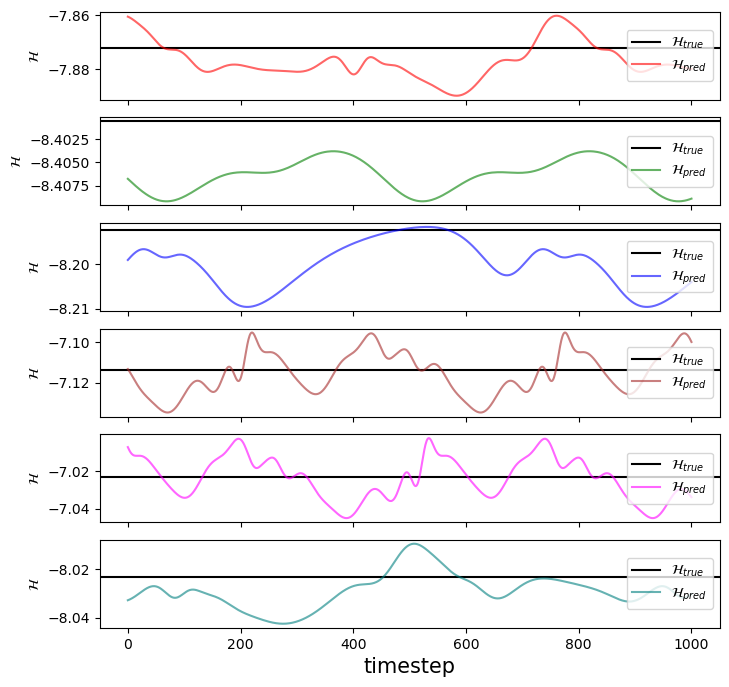

In [39]:
### Generate a few trajectories forward in time 

def create_subplots(h_pred, h_true):

  num_subplots = 6
  fig, axes = plt.subplots(nrows=num_subplots, figsize=(8, 8), sharex=True)

  colors = ['red', 'green', 'blue', 'brown', 'magenta', 'teal']

  for i in range(num_subplots):
    #axes[i].plot(np.arange(h.shape[1]), h2[i,:], color='black', alpha=0.6, label='$\mathcal{H}_{noisy}$')
    axes[i].axhline(y = h_true[i], xmin=0, xmax=h_pred.shape[1], color = 'black', label='$\mathcal{H}_{true}$')
    axes[i].plot(np.arange(h_pred.shape[1]), h_pred[i,:], color=colors[i], alpha=0.6, label='$\mathcal{H}_{pred}$')
    axes[i].set_ylabel("$\mathcal{H}$", fontsize=10)
    axes[i].legend(fontsize=10, loc="right")
  axes[5].set_xlabel("timestep", fontsize=15)

  plt.show()

pred_h_t = np.zeros((6,pred_trajs.shape[1]))

# pred_h_t represents the predicted trajectory with the model Hamiltonian
for i in range(pred_trajs.shape[1]):
    
    h_t_pred = model(test[6:12,i,:]).squeeze()
    pred_h_t[:,i] = h_t_pred.detach().numpy()

### Harmonic Oscillator ###
#h_t = (0.5*p_t**2) + (0.5*q_t**2)

### Double Well ###
#h_t = (0.5*(p_t**2) + 0.25*(q_t**4) - 0.5*(q_t**2))

### Coupled Oscillator ###
#pred_h_t = (0.5*p_t**2) + (0.5*q_t**2) + alpha*p_t*q_t
#h_t = (0.5*q_t**2) + (q_t*p_t**2) + (0.5*p_t**2) - (0.25*p_t**4) 
true_h_t = true_h_0[6:12]
create_subplots(pred_h_t, true_h_t + offset)

#### The code below is for the plots shown in the original paper for the Double well and Coupled Oscillator system (the model is evaluated here on a uniform grid) ####

In [42]:
num_pts=30
# Define grid
q_vals = np.linspace(-2, 2, num_pts)
p_vals = np.linspace(-2, 2, num_pts)
Q, P = np.meshgrid(q_vals, p_vals)

In [43]:
Y = torch.tensor([Q[0], P[0]], dtype=torch.float32).T
Y.shape
args = None

/tmp/ipykernel_4928/3779546590.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647176142/work/torch/csrc/utils/tensor_new.cpp:278.)
  Y = torch.tensor([Q[0], P[0]], dtype=torch.float32).T


In [45]:
num_pts = 30
pred_dyn_q = np.zeros((num_pts, num_pts))
pred_dyn_p = np.zeros((num_pts, num_pts))
true_dyn_q = np.zeros((num_pts, num_pts))
true_dyn_p = np.zeros((num_pts, num_pts))
pred_h = np.zeros((num_pts, num_pts))
true_h = np.zeros((num_pts, num_pts))
for i in range(Q.shape[1]):
    #pred_dyn = forward_ode(torch.tensor([Q[i,:],P[i,:]], dtype=torch.float32).T, (model,), (0,)).detach().numpy()
    pred_dyn = forward_ode(torch.tensor([Q[i,:],P[i,:]], dtype=torch.float32).T, (model,), (0,)).detach().numpy()
    pred_dyn_q[i,:] = pred_dyn[:,0]
    pred_dyn_p[i,:] = pred_dyn[:,1]
    #true_dyn = mass_spring(torch.tensor([Q[i,:],P[i,:]], dtype=torch.float32).T, args, None).detach().numpy()
    
    #Coupled HO
    #args = alpha
    #true_dyn = coupled_ho(torch.tensor([Q[i,:],P[i,:]], dtype=torch.float32).T, None, None).detach().numpy()
    #true_h[i,:] = 0.5*Q[i,:]**2 + 0.5*P[i,:]**2 + alpha*Q[i,:]*P[i,:]
    
    #Double Well
    true_dyn = double_well(torch.tensor([Q[i,:],P[i,:]], dtype=torch.float32).T, None, None).detach().numpy()
    true_h[i,:] = (0.5*(P[i,:]**2) + 0.25*(Q[i,:]**4) - 0.5*(Q[i,:]**2))

    #pred_h[i,:] = model(torch.tensor([Q[i,:],P[i,:]], dtype=torch.float32).T).squeeze().detach().numpy() - offset
    pred_h[i,:] = model(torch.tensor([Q[i,:],P[i,:]], dtype=torch.float32).T).squeeze().detach().numpy()
    true_dyn_q[i,:] = true_dyn[:,0]
    true_dyn_p[i,:] = true_dyn[:,1]

offset = (pred_h - true_h).mean()

In [46]:
offset = np.mean(offsets)

In [47]:
pred_h_corrected = pred_h - offset

In [48]:
abs_error = np.abs(pred_h_corrected - true_h)
mean_abs_error = abs_error.mean()
print(mean_abs_error)

0.011303796275567211


In [49]:
print(mean_abs_error)

0.011303796275567211


In [50]:
# Compute error
h_diff = np.abs(true_h - pred_h)
dq_error = true_dyn_q - pred_dyn_q
dp_error = true_dyn_p - pred_dyn_p

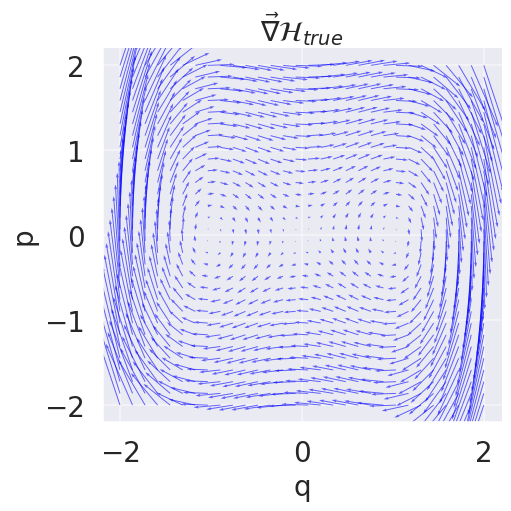

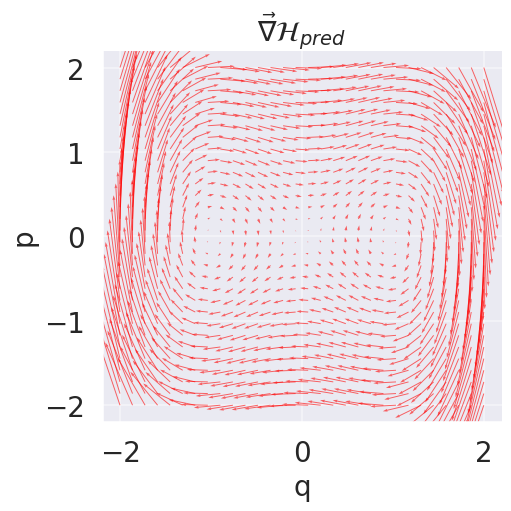

/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/seaborn/axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


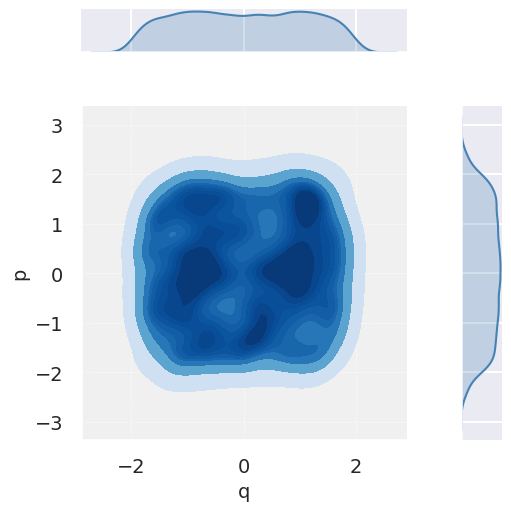

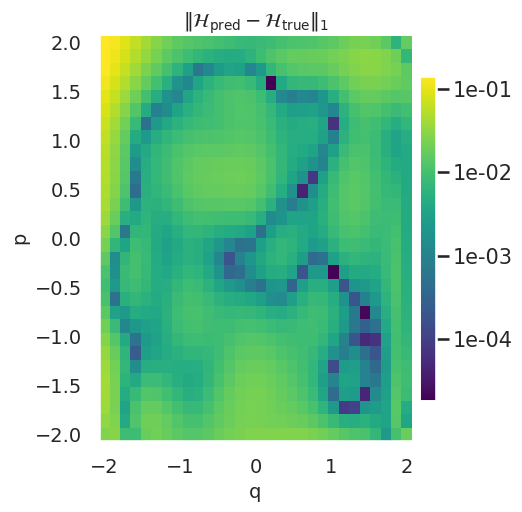

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, FuncFormatter, ScalarFormatter

# Set Seaborn style with larger context
sns.set_style("darkgrid")
sns.set_context("talk", font_scale=2.0)

fontsize = 20
scale_factor = 30

# ======= True dynamics quiver plot ======= #
fig1, ax1 = plt.subplots(figsize=(6, 6))
ax1.quiver(
    Q, P, true_dyn_q, true_dyn_p,
    color='blue', scale=scale_factor, alpha=0.6
)
ax1.set_title(r'$\vec\nabla\mathcal{H}_{true}$', fontsize=fontsize)
ax1.set_xlabel('q', fontsize=fontsize)
ax1.set_ylabel('p', fontsize=fontsize)
ax1.tick_params(axis='both', labelsize=fontsize)
sns.despine()
ax1.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# ======= Predicted dynamics quiver plot ======= #
fig2, ax2 = plt.subplots(figsize=(6, 6))
ax2.quiver(
    Q, P, pred_dyn_q, pred_dyn_p,
    color='red', scale=scale_factor, alpha=0.6
)
ax2.set_title(r'$\vec\nabla\mathcal{H}_{pred}$', fontsize=fontsize)
ax2.set_xlabel('q', fontsize=fontsize)
ax2.set_ylabel('p', fontsize=fontsize)
ax2.tick_params(axis='both', labelsize=fontsize)
sns.despine()
ax2.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# ======= Henon Heiles KDE jointplot ======= #
flat = train[::10, ::200, :].reshape(-1, 2)
df = pd.DataFrame({'q': flat[:, 0], 'p': flat[:, 1]})

fontsize = 14  # Adjust as needed

# Create a JointGrid for better layout control
g = sns.JointGrid(data=df, x="q", y="p", height=6, ratio=4, space=0.2)

# Draw the KDE on joint and marginal axes
g.plot_joint(sns.kdeplot, fill=True, cmap="Blues", thresh=0.05)
g.plot_marginals(sns.kdeplot, fill=True, color="steelblue")

# Style
g.ax_joint.set_facecolor("#f0f0f0")
g.ax_joint.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
g.ax_joint.set_xlabel("q", fontsize=fontsize)
g.ax_joint.set_ylabel("p", fontsize=fontsize)
g.ax_joint.tick_params(axis='both', labelsize=fontsize)

plt.tight_layout()
plt.show()

# ======= Heatmap of Hamiltonian error ======= #
fig3, ax3 = plt.subplots(figsize=(6, 6))
c = ax3.pcolormesh(
    Q, P, np.abs(pred_h_corrected - true_h),
    shading="auto", cmap="viridis",
    norm=LogNorm(
        vmin=np.abs(pred_h_corrected - true_h).min(),
        vmax=np.abs(pred_h_corrected - true_h).max()
    )
)


# 1) create a ScalarFormatter configured for scientific notation
# 1) make the colorbar, slim and close
cb = plt.colorbar(c, ax=ax3, shrink=0.8, pad=0.02)

# 2) tell it to only use pure powers-of-10 between your data limits
cb.locator = LogLocator(base=10.0, subs=(1.0,), numticks=10)
cb.update_ticks()

# 3) format each tick as '1e-2', '1e-1', '1', etc.
cb.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0e}"))

# 4) remove any minor ticks and shrink the tick labels
cb.ax.minorticks_off()
cb.ax.tick_params(axis='y', labelsize=15)

# …then your usual labels, title, etc.
ax3.set_title(r"$\|\mathcal{H}_{\mathrm{pred}} - \mathcal{H}_{\mathrm{true}}\|_1$", fontsize=fontsize)
ax3.set_xlabel("q", fontsize=fontsize)
ax3.set_ylabel("p", fontsize=fontsize)
ax3.tick_params(axis='both', labelsize=fontsize)
sns.despine()
ax3.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### The code below is for the plots shown in the original paper for the Henon-Heiles system (the model is evaluated here on a uniform grid) ####

In [341]:
#################  For Henon Heiles  ##################
num_pts = 20
# Extract min/max values from the dataset
q1_min, q1_max = torch.min(test_noisy[:,:,0]), torch.max(test_noisy[:,:,0])
p1_min, p1_max = torch.min(test_noisy[:,:,2]), torch.max(test_noisy[:,:,2])
q2_min, q2_max = torch.min(test_noisy[:,:,1]), torch.max(test_noisy[:,:,1])
p2_min, p2_max = torch.min(test_noisy[:,:,3]), torch.max(test_noisy[:,:,3])

# Create 1D grids
q_vals_1 = np.linspace(q1_min, q1_max, num_pts)
p_vals_1 = np.linspace(p1_min, p1_max, num_pts)
q_vals_2 = np.linspace(q2_min, q2_max, num_pts)
p_vals_2 = np.linspace(p2_min, p2_max, num_pts)

# Create a full 4D meshgrid
Q1, P1, Q2, P2 = np.meshgrid(q_vals_1, p_vals_1, q_vals_2, p_vals_2, indexing='ij')

# The resulting arrays are 4D tensors of shape (num_pts, num_pts, num_pts, num_pts)
print(Q1.shape, P1.shape, Q2.shape, P2.shape)  # Should print (num_pts, num_pts, num_pts, num_pts)


(20, 20, 20, 20) (20, 20, 20, 20) (20, 20, 20, 20) (20, 20, 20, 20)


In [342]:
print(q1_min, q1_max)
print(p1_min, p1_max)
print(q2_min, q2_max)
print(p2_min, p2_max)

tensor(-0.6719) tensor(0.6013)
tensor(-0.5646) tensor(0.5205)
tensor(-0.4767) tensor(0.6043)
tensor(-0.4798) tensor(0.4954)


In [343]:
print(q1_min, q1_max)

tensor(-0.6719) tensor(0.6013)


In [344]:
pred_dyn_q1 = np.zeros((num_pts, num_pts, num_pts, num_pts))
pred_dyn_q2 = np.zeros((num_pts, num_pts, num_pts, num_pts))
pred_dyn_p1 = np.zeros((num_pts, num_pts, num_pts, num_pts))
pred_dyn_p2 = np.zeros((num_pts, num_pts, num_pts, num_pts))
true_dyn_q1 = np.zeros((num_pts, num_pts, num_pts, num_pts))
true_dyn_q2 = np.zeros((num_pts, num_pts, num_pts, num_pts))
true_dyn_p1 = np.zeros((num_pts, num_pts, num_pts, num_pts))
true_dyn_p2 = np.zeros((num_pts, num_pts, num_pts, num_pts))
true_h = np.zeros((num_pts, num_pts, num_pts, num_pts))
pred_h = np.zeros((num_pts, num_pts, num_pts, num_pts))

for i in range(num_pts):
    for j in range(num_pts):
        for k in range(num_pts):
            for l in range(num_pts):
                 
                q1 = q_vals_1[i]
                q2 = q_vals_2[j]
                p1 = p_vals_1[k]
                p2 = p_vals_2[l]

                state = torch.tensor([[q1, q2, p1, p2]], dtype=torch.float32)
                # Predicted dynamics using the learned model
                pred_dyn = forward_ode(state, (model,), (0,)).detach().numpy()

                pred_dyn_q1[i, j, k, l] = pred_dyn[:, 0]
                pred_dyn_q2[i, j, k, l] = pred_dyn[:, 1]
                pred_dyn_p1[i, j, k, l] = pred_dyn[:, 2]
                pred_dyn_p2[i, j, k, l] = pred_dyn[:, 3]

                # True dynamics
                true_dyn = henon_heiles(state, None, None).detach().numpy()
                true_dyn_q1[i, j, k, l] = true_dyn[:, 0]
                true_dyn_q2[i, j, k, l] = true_dyn[:, 1]
                true_dyn_p1[i, j, k, l] = true_dyn[:, 2]
                true_dyn_p2[i, j, k, l] = true_dyn[:, 3]

                # Hamiltonian values
                true_h[i, j, k, l] = (0.5*(p1**2 + p2**2) + 0.5*(q1**2 + q2**2) + (q1**2)*(q2) - ((q2**3)/3))
                #pred_h[i, j, k, l] = model(state).squeeze().detach().numpy() - offset

                pred_h[i, j, k, l] = model(state).squeeze().detach().numpy()

                
offset = np.mean(pred_h - true_h)

/tmp/ipykernel_13454/839109904.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_dyn_q1[i, j, k, l] = pred_dyn[:, 0]
/tmp/ipykernel_13454/839109904.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_dyn_q2[i, j, k, l] = pred_dyn[:, 1]
/tmp/ipykernel_13454/839109904.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_dyn_p1[i, j, k, l] = pred_dyn[:, 2]
/tmp/ipykernel_13454/839109904.py:29: DeprecationWarning: Conversion of an array with ndim > 0

In [345]:
pred_h_corrected = pred_h - offset

In [346]:
mean_abs_error = np.abs(pred_h_corrected - true_h)

In [347]:
# Compute error
h_diff = np.abs(pred_h_corrected - true_h)
error_dyn_q = true_dyn_q2 - pred_dyn_q2
error_dyn_p = true_dyn_p2 - true_dyn_p2

In [348]:
ind_q1 = 10
ind_p1 = 10

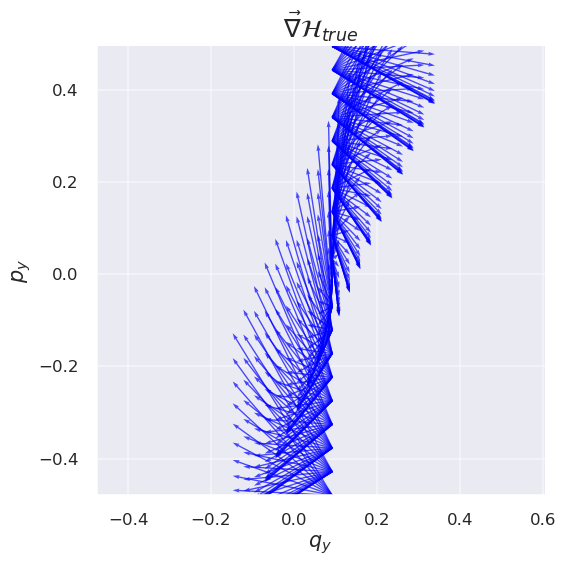

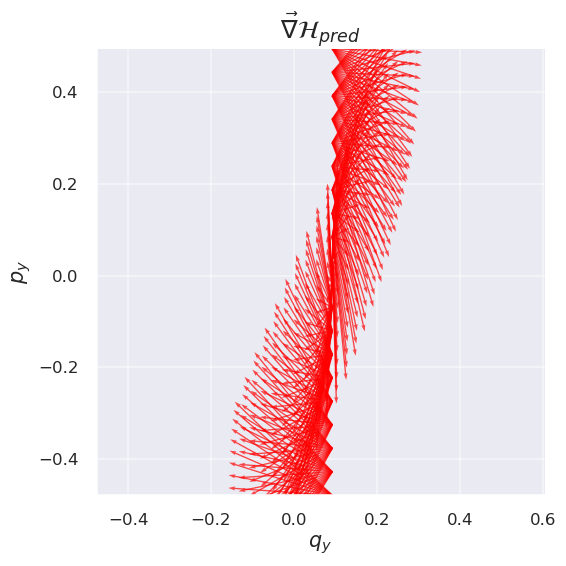

IndexError: index 3 is out of bounds for dimension 0 with size 2

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, FuncFormatter, ScalarFormatter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set Seaborn style
sns.set_style("darkgrid")
sns.set_context("talk", font_scale=1.0)

scale_factor = 30

# ======= True dynamics quiver plot ======= #
fig1, ax1 = plt.subplots(figsize=(6, 6))
q_vals = Q2[ind_q1, :, ind_p1, :]
p_vals = P2[ind_q1, :, ind_p1, :]
dq = true_dyn_q2[ind_q1, :, ind_p1, :]
dp = true_dyn_p2[ind_q1, :, ind_p1, :]

ax1.quiver(q_vals, p_vals, dq, dp, angles='xy', scale_units='xy', scale=2, color='blue', alpha=0.7)
ax1.set_xlim(q2_min, q2_max)
ax1.set_ylim(p2_min, p2_max)
ax1.set_xlabel(r'$q_y$', fontsize=15)
ax1.set_ylabel(r'$p_y$', fontsize=15)
ax1.set_title(r'$\vec\nabla\mathcal{H}_{true}$', fontsize=18)
ax1.tick_params(axis='both', labelsize=12)
sns.despine()
ax1.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# ======= Predicted dynamics quiver plot ======= #
fig2, ax2 = plt.subplots(figsize=(6, 6))
dq_pred = pred_dyn_q2[ind_q1, :, ind_p1, :]
dp_pred = pred_dyn_p2[ind_q1, :, ind_p1, :]

ax2.quiver(q_vals, p_vals, dq_pred, dp_pred, angles='xy', scale_units='xy', scale=2, color='red', alpha=0.7)
ax2.set_xlim(q2_min, q2_max)
ax2.set_ylim(p2_min, p2_max)
ax2.set_xlabel(r'$q_y$', fontsize=15)
ax2.set_ylabel(r'$p_y$', fontsize=15)
ax2.set_title(r'$\vec\nabla\mathcal{H}_{pred}$', fontsize=18)
ax2.tick_params(axis='both', labelsize=12)
sns.despine()
ax2.grid(alpha=0.4)
plt.tight_layout()
plt.show()

######## Henon Heiles #########
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Flatten the data across selected trajectories and time
flat = train[::10, ::100, [1, 3]].reshape(-1, 2)
q = flat[:, 0]
p = flat[:, 1]

# Create a DataFrame for seaborn
df = pd.DataFrame({'q': q, 'p': p})

# Set darkgrid style
sns.set_style("darkgrid")  # 'darkgrid', 'whitegrid', 'dark', 'white', and 'ticks'
sns.set_context("talk", font_scale=1.2)

# Plot using seaborn jointplot with KDE
g = sns.jointplot(
    data=df,
    x="q", y="p",
    kind="kde", fill=True,
    cmap="Blues", thresh=0.05,
    height=6
)

# Customize axes and background
g.ax_joint.set_facecolor("#f0f0f0")  # Light grey background
g.ax_joint.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

g.ax_joint.set_xlabel(r"$q_y$", fontsize=20)
g.ax_joint.set_ylabel(r"$p_y$", fontsize=20)

g.ax_joint.tick_params(axis='both', labelsize=10)

#plt.suptitle("2D KDE of Phase Space Trajectories", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


# --- Plot heatmap with proper slicing --- #
fig, ax = plt.subplots(figsize=(6, 6))

# Recreate X, Y grid matching data
q = np.linspace(q1_min, q1_max, h_diff.shape[1])
p = np.linspace(p1_min, p1_max, h_diff.shape[3])
Q, P = np.meshgrid(q, p, indexing='ij')  # CAREFUL: indexing = 'ij' matches array layout!

# Now plot
c = ax.pcolormesh(
    Q, P, np.abs(h_diff[ind_q1, :, ind_p1, :]),
    shading="auto",
    cmap="viridis",
    norm=LogNorm(
        vmin=np.abs(h_diff[ind_q1, :, ind_p1, :]).min(),
        vmax=np.abs(h_diff[ind_q1, :, ind_p1, :]).max()
    )
)

# Colorbar
cb = plt.colorbar(c, ax=ax, ticks=LogLocator(base=10.0, subs=[1.0], numticks=5))
cb.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:g}"))
#cb.ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
cb.ax.tick_params(which='both', direction='in', width=1, length=5, labelsize=10)

# Axis labels and styling
ax.set_xlabel(r"$q_y$", fontsize=20)
ax.set_ylabel(r"$p_y$", fontsize=20)
ax.set_title(r"$\|\mathcal{H}_{\mathrm{pred}} - \mathcal{H}_{\mathrm{true}}\|_1$", fontsize=20)
ax.tick_params(axis='both', labelsize=10)

sns.despine()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### The code below plots the Hamiltonian prediction error on data sampled from three different distributions : Random Uniform, Uniform Grid, Gaussian ###

In [53]:
import numpy as np
import torch

def _evaluate_batch(
    Y,
    model,
    forward_ode,
    true_dyn_fn,
    true_dyn_args=(),
    true_dyn_kwargs=None,
    true_h_fn=None,
):
    """
    Evaluate model vs ground truth on the batch Y (shape (N,2)).
    - forward_ode(Y, (model,), (0,)) → Tensor (N,2)
    - true_dyn_fn(Y, *true_dyn_args, **true_dyn_kwargs) → Tensor (N,2)
    - true_h_fn(q_array, p_array) → numpy (N,)
    """
    if true_dyn_kwargs is None:
        true_dyn_kwargs = {}

    # 1) Model predictions
    with torch.no_grad():
        pred_dyn = (
            forward_ode(Y, (model,), (0,))
            .detach()
            .cpu()
            .numpy()
        )  # (N,2)
        pred_h = (
            model(Y)
            .squeeze()
            .detach()
            .cpu()
            .numpy()
        )  # (N,)

    # 2) True dynamics (allow extra args/kwargs)
    true_dyn = (
        true_dyn_fn(Y, *true_dyn_args, **true_dyn_kwargs)
        .detach()
        .cpu()
        .numpy()
    )  # (N,2)

    # 3) True Hamiltonian
    q = Y[:, 0].cpu().numpy()
    p = Y[:, 1].cpu().numpy()
    if true_h_fn is None:
        raise ValueError("Please supply true_h_fn(q,p) → numpy array")
    true_h = true_h_fn(q, p)  # (N,)

    # 4) Offset correction & errors
    offset = np.mean(pred_h - true_h)
    pred_h_corr = pred_h - offset

    h_err = np.abs(pred_h_corr - true_h)
    mean_abs_h = float(h_err.mean())

    dq_err = true_dyn[:, 0] - pred_dyn[:, 0]
    dp_err = true_dyn[:, 1] - pred_dyn[:, 1]

    return {
        "pred_dyn":    pred_dyn,
        "true_dyn":    true_dyn,
        "pred_h":      pred_h,
        "true_h":      true_h,
        "offset":      offset,
        "pred_h_corr": pred_h_corr,
        "h_error":     h_err,
        "mean_abs_h":  mean_abs_h,
        "dq_error":    dq_err,
        "dp_error":    dp_err,
    }

In [54]:
def evaluate_on_uniform_grid(
    model,
    forward_ode,
    true_dyn_fn,
    true_h_fn,
    num_pts=30,
    xlim=(-2, 2),
    ylim=(-2, 2),
    device="cpu",
    true_dyn_args=(),
    true_dyn_kwargs=None,
):
    """
    Uniform grid in [xlim]×[ylim], num_pts per axis.
    Returns a dict with Q,P mesh plus error arrays shaped (num_pts,num_pts).
    """
    # build grid
    qv = np.linspace(xlim[0], xlim[1], num_pts)
    pv = np.linspace(ylim[0], ylim[1], num_pts)
    Q, P = np.meshgrid(qv, pv)
    pts = np.stack([Q.ravel(), P.ravel()], axis=1)  # (N,2)
    Y = torch.tensor(pts, dtype=torch.float32, device=device)

    out = _evaluate_batch(
        Y,
        model,
        forward_ode,
        true_dyn_fn,
        true_dyn_args=true_dyn_args,
        true_dyn_kwargs=true_dyn_kwargs,
        true_h_fn=true_h_fn,
    )

    # reshape back to grid
    for key in ("h_error", "dq_error", "dp_error"):
        out[key] = out[key].reshape(num_pts, num_pts)
    out["Q"], out["P"] = Q, P
    return out

In [55]:
def evaluate_on_random_uniform(
    model,
    forward_ode,
    true_dyn_fn,
    true_h_fn,
    num_samples=1000,
    xlim=(-2, 2),
    ylim=(-2, 2),
    device="cpu",
    true_dyn_args=(),
    true_dyn_kwargs=None,
):
    """
    num_samples uniform points in [xlim]×[ylim].
    Returns the raw 1D‐array results in the same dict format as _evaluate_batch.
    """
    q = np.random.uniform(xlim[0], xlim[1], size=num_samples)
    p = np.random.uniform(ylim[0], ylim[1], size=num_samples)
    pts = np.column_stack([q, p])
    Y = torch.tensor(np.stack([q, p], axis=1), dtype=torch.float32, device=device)

    out = _evaluate_batch(
        Y,
        model,
        forward_ode,
        true_dyn_fn,
        true_dyn_args=true_dyn_args,
        true_dyn_kwargs=true_dyn_kwargs,
        true_h_fn=true_h_fn,
    )
    out["coords"] = pts
    return out

In [56]:
def evaluate_on_gaussian(
    model,
    forward_ode,
    true_dyn_fn,
    true_h_fn,
    num_samples=1000,
    mean=(0, 0),
    cov=[[1, 0], [0, 1]],
    device="cpu",
    true_dyn_args=(),
    true_dyn_kwargs=None,
):
    """
    num_samples points from N(mean, cov).
    Returns the raw 1D‐array results in the same dict format as _evaluate_batch.
    """
    pts = np.random.multivariate_normal(mean, cov, size=num_samples)
    Y = torch.tensor(pts, dtype=torch.float32, device=device)

    out = _evaluate_batch(
        Y,
        model,
        forward_ode,
        true_dyn_fn,
        true_dyn_args=true_dyn_args,
        true_dyn_kwargs=true_dyn_kwargs,
        true_h_fn=true_h_fn,
    )
    out["coords"] = pts
    return out

In [57]:
def true_h_fn(q,p):
    return 0.5*p**2 + 0.25*q**4 - 0.5*q**2
    #return 0.5*p**2 + 0.5*q**2 + alpha*p*q

# Wrap double_well so it gets the two None arguments
def true_dyn_fn(Y, args=None, kargs=None):
    return double_well(Y, args, kargs)
    #return coupled_ho(Y, args=None, kargs=None)

In [58]:
# 1) Uniform grid
res_grid = evaluate_on_uniform_grid(
    model,
    forward_ode,
    true_dyn_fn,
    true_h_fn,
    num_pts=30,
    true_dyn_args=(),
    true_dyn_kwargs={},    # or {"args": None, "kargs": None}
)
Q, P = res_grid["Q"], res_grid["P"]
h_error_grid = res_grid["h_error"]

In [59]:
num_rand = 100000
q_rand = np.random.uniform(-2,2,num_rand)
p_rand = np.random.uniform(-2,2,num_rand)
# 2) Uniform random
res_rand = evaluate_on_random_uniform(
    model,
    forward_ode,
    true_dyn_fn,
    true_h_fn,
    num_samples=100000,
)

q_rand, p_rand   = res_rand["coords"].T
h_error_rand = res_rand["h_error"]

In [60]:
# 3) Gaussian
num_gauss = 100000
mean = (0,0)
cov  = [[1,0],[0,1]]
pts_gauss = np.random.multivariate_normal(mean, cov, size=num_gauss)
res_gauss = evaluate_on_gaussian(
    model,
    forward_ode,
    true_dyn_fn,
    true_h_fn,
    num_samples=100000,
    mean=(0,0),
    cov=[[1,0],[0,1]],
)

q_gauss, p_gauss = res_gauss["coords"].T
h_error_gauss = res_gauss["h_error"]

In [61]:
print(res_rand["h_error"].mean())
print(res_grid["h_error"].mean())
print(res_gauss["h_error"].mean())

0.010404063
0.011577721
0.15245871


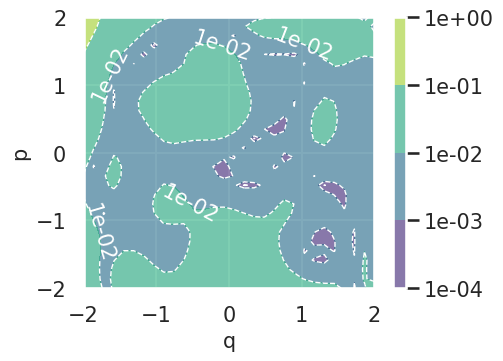

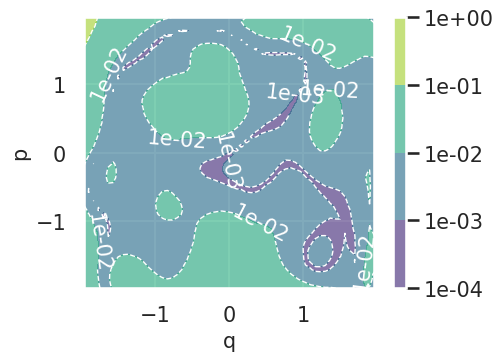

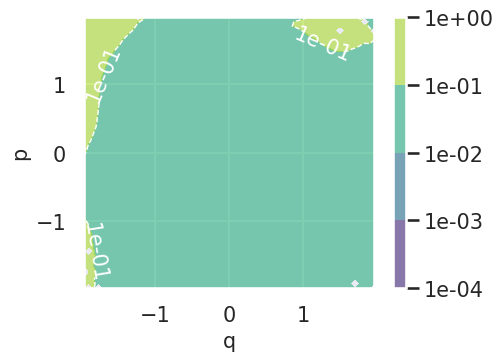

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter
from scipy.stats import binned_statistic_2d

# ---------------------------------------------------
# Shared settings
# ---------------------------------------------------
bands      = [1e-4, 1e-3, 1e-2, 1e-1, 1]
fontsize   = 15
norm       = LogNorm(vmin=bands[0], vmax=bands[-1])
cbar_fmt   = ScalarFormatter(useMathText=True)
cbar_ticks = bands

# ---------------------------------------------------
# Helper: bin (q,p,h) onto a grid for contouring
# ---------------------------------------------------
def compute_binned_mean(q, p, h, bins=60, range=[[-2,2],[-2,2]]):
    stat, xe, ye, _ = binned_statistic_2d(
        q, p, h, statistic="mean",
        bins=bins, range=range
    )
    xc = (xe[:-1] + xe[1:]) / 2
    yc = (ye[:-1] + ye[1:]) / 2
    return stat.T, np.meshgrid(xc, yc)

# ---------------------------------------------------
# Unpack your data
# ---------------------------------------------------
# 1) Uniform grid
Q, P       = res_grid["Q"], res_grid["P"]
h_grid     = res_grid["h_error"]

# 2) Uniform-random
coords_rand = res_rand["coords"]
q_rand, p_rand = coords_rand.T
h_rand       = res_rand["h_error"]
stat_rand, (Qr, Pr) = compute_binned_mean(q_rand, p_rand, h_rand)

# 3) Gaussian
coords_gauss = res_gauss["coords"]
q_gauss, p_gauss = coords_gauss.T
h_gauss        = res_gauss["h_error"]
stat_gauss, (Qg, Pg) = compute_binned_mean(q_gauss, p_gauss, h_gauss)

# ---------------------------------------------------
# Plot 1: Grid data with discrete filled bands
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4.5))
cf = ax.contourf(
    Q, P, h_grid,
    levels=bands,
    cmap='viridis',
    norm=norm,
    alpha=0.6
)
cs = ax.contour(
    Q, P, h_grid,
    levels=bands,
    colors='white',
    linestyles='--',
    linewidths=1.0
)
ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors='white')

#ax.set_title("Grid $|H_{pred}-H_{true}|$ bands", fontsize=fontsize)
ax.set_xlabel("q", fontsize=fontsize)
ax.set_ylabel("p", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

cbar = plt.colorbar(cf, ax=ax, ticks=cbar_ticks, format=cbar_fmt)
cbar.ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0e}")
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()

# ---------------------------------------------------
# Plot 2: Uniform‐random data with discrete filled bands
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4.5))
cf = ax.contourf(
    Qr, Pr, stat_rand,
    levels=bands,
    cmap='viridis',
    norm=norm,
    alpha=0.6
)
cs = ax.contour(
    Qr, Pr, stat_rand,
    levels=bands,
    colors='white',
    linestyles='--',
    linewidths=1.0
)
ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors='white')

#ax.set_title("Uniform‐Random $|H_{pred}-H_{true}|$ bands", fontsize=fontsize)
ax.set_xlabel("q", fontsize=fontsize)
ax.set_ylabel("p", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

cbar = plt.colorbar(cf, ax=ax, ticks=cbar_ticks, format=cbar_fmt)
cbar.ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0e}")
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()

# ---------------------------------------------------
# Plot 3: Gaussian data with discrete filled bands
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4.5))
cf = ax.contourf(
    Qg, Pg, stat_gauss,
    levels=bands,
    cmap='viridis',
    norm=norm,
    alpha=0.6
)
cs = ax.contour(
    Qg, Pg, stat_gauss,
    levels=bands,
    colors='white',
    linestyles='--',
    linewidths=1.0
)
ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors='white')

#ax.set_title("Gaussian $|H_{pred}-H_{true}|$ bands", fontsize=fontsize)
ax.set_xlabel("q", fontsize=fontsize)
ax.set_ylabel("p", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

cbar = plt.colorbar(cf, ax=ax, ticks=cbar_ticks, format=cbar_fmt)
cbar.ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0e}")
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()


### For Henon Heiles ###

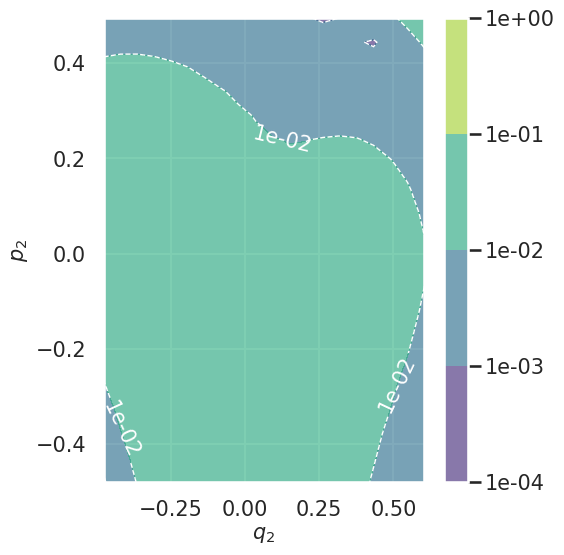

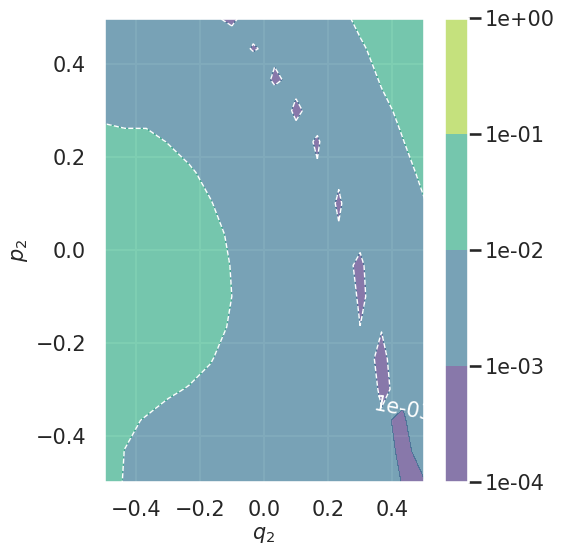

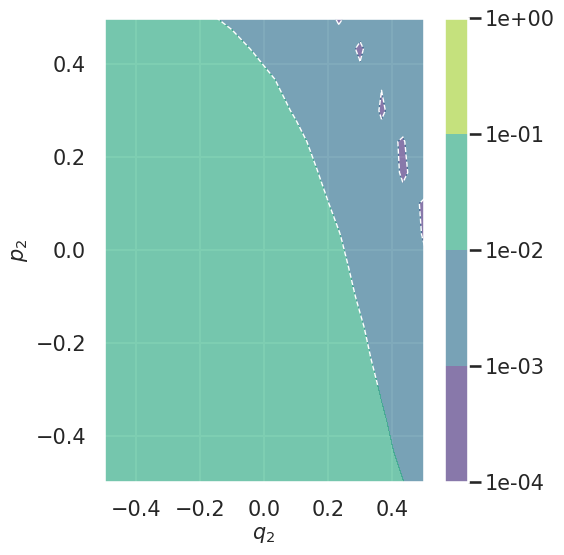

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, ScalarFormatter, FuncFormatter

# --- slice indices in the 4D grid ---
# pick your slice indices
ind_q1, ind_p1 = 10, 10

# the correct slice
Q2slice = Q2[ind_q1, ind_p1, :, :]    # shape (num_pts, num_pts)
P2slice = P2[ind_q1, ind_p1, :, :]
h_slice  = h_diff[ind_q1, ind_p1, :, :]

# ranges for axis-limits
q2_min, q2_max = q_vals_2.min(), q_vals_2.max()
p2_min, p2_max = p_vals_2.min(), p_vals_2.max()
# offset computed from full pred_h - true_h before
# pred_h_corrected = pred_h - offset
# (reuse that offset here for consistency)

# ----------------------------------------------------------------
# 1) GRID: discrete filled bands + dashed contours
# ----------------------------------------------------------------
bands    = [1e-4, 1e-3, 1e-2, 1e-1, 1]
fontsize = 15

q1_val = float(q_vals_1[ind_q1])
p1_val = float(p_vals_1[ind_p1])

fig, ax = plt.subplots(figsize=(6,4.5))
cf = ax.contourf(
    Q2slice, P2slice, h_slice,
    levels=bands,
    cmap='viridis',
    norm=LogNorm(vmin=bands[0], vmax=bands[-1]),
    alpha=0.6
)
cs = ax.contour(
    Q2slice, P2slice, h_slice,
    levels=bands,
    colors='white',
    linestyles='--',
    linewidths=1.0
)
ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors='white')

# explicitly fix the x/y limits to match your other plots
ax.set_xlim(q2_min, q2_max)
ax.set_ylim(p2_min, p2_max)

#ax.set_title("Grid slice $|H_{pred}-H_{true}|$", fontsize=fontsize)
ax.set_xlabel(r"$q_2$", fontsize=fontsize)
ax.set_ylabel(r"$p_2$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

cbar = plt.colorbar(cf, ax=ax, ticks=bands, format=ScalarFormatter(useMathText=True))
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0e}"))
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()

# shared band settings
bands      = [1e-4, 1e-3, 1e-2, 1e-1, 1]
norm       = LogNorm(vmin=bands[0], vmax=bands[-1])
fontsize   = 15

# helper to bin (q,p,h) onto a grid
def compute_binned_mean(q, p, h, bins=60, range=[[-2,2],[-2,2]]):
    stat, xe, ye, _ = binned_statistic_2d(
        q, p, h, statistic="mean", bins=bins, range=range
    )
    xc = (xe[:-1] + xe[1:]) / 2
    yc = (ye[:-1] + ye[1:]) / 2
    return stat.T, np.meshgrid(xc, yc)

# unpack uniform‐random data
coords_rand = res_rand["coords"]
q_rand, p_rand = coords_rand.T
h_rand = res_rand["h_error"]
stat_rand, (Qr, Pr) = compute_binned_mean(q_rand, p_rand, h_rand)

# unpack gaussian data
coords_gauss = res_gauss["coords"]
q_gauss, p_gauss = coords_gauss.T
h_gauss = res_gauss["h_error"]
stat_gauss, (Qg, Pg) = compute_binned_mean(q_gauss, p_gauss, h_gauss)

# obtain slice ranges
q2_min, q2_max = Qr.min(), Qr.max()
p2_min, p2_max = Pr.min(), Pr.max()

# ---- Plot: Uniform‐random with discrete bands ----
fig, ax = plt.subplots(figsize=(6,4.5))
cf = ax.contourf(
    Qr, Pr, stat_rand,
    levels=bands,
    cmap='viridis',
    norm=norm,
    alpha=0.6
)
cs = ax.contour(
    Qr, Pr, stat_rand,
    levels=bands,
    colors='white',
    linestyles='--',
    linewidths=1.0
)
ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors='white')

#ax.set_title("Uniform‐Random slice $|H_{pred}-H_{true}|$", fontsize=fontsize)
ax.set_xlabel(r"$q_2$", fontsize=fontsize)
ax.set_ylabel(r"$p_2$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)

cbar = plt.colorbar(cf, ax=ax, ticks=bands, format=ScalarFormatter(useMathText=True))
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0e}"))
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()

# ---- Plot: Gaussian with discrete bands ----
fig, ax = plt.subplots(figsize=(6,4.5))
cf = ax.contourf(
    Qg, Pg, stat_gauss,
    levels=bands,
    cmap='viridis',
    norm=norm,
    alpha=0.6
)
cs = ax.contour(
    Qg, Pg, stat_gauss,
    levels=bands,
    colors='white',
    linestyles='--',
    linewidths=1.0
)
ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors='white')

#ax.set_title("Gaussian slice $|H_{pred}-H_{true}|$", fontsize=fontsize)
ax.set_xlabel(r"$q_2$", fontsize=fontsize)
ax.set_ylabel(r"$p_2$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)

cbar = plt.colorbar(cf, ax=ax, ticks=bands, format=ScalarFormatter(useMathText=True))
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0e}"))
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()